# Applied Data Science Capstone by IBM/ Coursera (Week 2)

## Peer-graded Assignment: The Battle of Neighborhoods (Cont'd)

NNG DUOJIEZHAXI
IBM Data Science Professional

## Table of contents

- Introduction: Business Problem
- Data
- Methodology
- Analysis
- Results and Discussion
- Conclusion

## 1) Introduction

This final project explores the best locations for Tibetan restaurants throughout the Queens of New York. New York City (NYC), often called New York (NY), is the most populous city in the United States. With an estimated 2019 population of 8,336,817 distributed over about 302.6 square miles (784 km2), New York is also the most densely populated major city in the United States. Located at the southern tip of the U.S. state of New York, the city is the center of the New York metropolitan area, the largest metropolitan area in the world by urban landmass. 

New York has one of the largest Tibetan populations outside of Tibet, China, India and Nepal, and many Tibetans are concentrated in Queens. The Office of Tibet in New York estimates that there are approximately 9,000 Tibetans living in New York as of 2008. Since there are some Tibetan restaurants in Queens, New York we will try to detect locations that are not already crowded with restaurants.  We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

### Target Audience 
In this project we will be targeted to stakeholders who are interested in opening a Tibetan restaurant in Queens, New York by choosing the right location and providing data about the income and population of each neighborhood as well as the competitors already present on the same regions. 


### Data Section
For this project we need the following data:
New York City data that contains Borough, Neighborhoods along with there latitudes and longitudes. 
* Data Source: https://cocl.us/new_york_dataset
* Description: This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city. 

Tibetan restaurants in new york city.
* Data Source: Foursquare API
* Description: By using this API we will get all the venues in neighborhoods from 5 boroughs of NYC. We can filter these venues to get only Tibetan restaurants.

### Approch
We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods. Following data sources will be needed to extract/generate the required information:
Collect the new york city data from https://cocl.us/new_york_dataset

Using Foursquare API we will get all venues for each neighborhood and number of restaurants and their type and location in every neighborhood
Filter out all venues which are Tibetan Restaurants, centers of candidate areas and approximate addresses of centers of those areas obtained using Google Maps API reverse geocoding
Data Visualization and some statistical analysis.
Analysing using Clustering (Specially K-Means):\
Find the best value of K\
Visualize the neighborhood with number of Tibetan Restaurants.
Compare the Neighborhoods to Find the Best Place for Starting up a Restaurant
Inference From these Results and related Conclusions

### Problem Statement
Based on definition of our problem, factors that will influence our decission are:
- What is the best location for a Tibetan restaurant in Queens, New York City?
- In what Neighborhood should I open a Tibetan restaurant to have the best chance of being successful?

##  2) Data Preparation:
Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which is aprox. 12x12 killometers centered around Queens, New York.

Let's first find the latitude & longitude of Queens, using specific, well known address and Google Maps geocoding API.

In [1]:
get_ipython().system('pip install folium')

     |████████████████████████████████| 102kB 8.7MB/s ta 0:00:011


In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

###  Using Foursquare Location Data:
Foursquare data is very comprehensive and it powers location data for Apple, Uber etc. For this business problem I have used, as a part of the assignment, the Foursquare API to retrieve information about the Venue, Venue category with there longitudes and latitudes. The call returns a JSON file and we need to turn that into a data-frame. Here I’ve chosen 100 popular spots for each neighborhoods a radius of 500 meters. Below is the data-frame obtained from the JSON file that was returned by Foursquare —

In [28]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '2U1PWGHXS5HUJBDW1ROXUGWVGXUWNNWUGEQBPYBDZON3OIUM'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='Q3HR0HP0NKWQCKDUPQP1TUCU1RQEZTATV5HGPHMBJX1CMJT0' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20190605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [29]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '2U1PWGHXS5HUJBDW1ROXUGWVGXUWNNWUGEQBPYBDZON3OIUM'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='Q3HR0HP0NKWQCKDUPQP1TUCU1RQEZTATV5HGPHMBJX1CMJT0' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20190605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [30]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [31]:
# get new york data
new_york_data=get_new_york_data()

In [32]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [33]:
new_york_data.shape

(306, 4)

Now that we have our initial data, lets start analyzing it. We can see below that Manhattan has the least number of neighborhoods in all five buroughs.

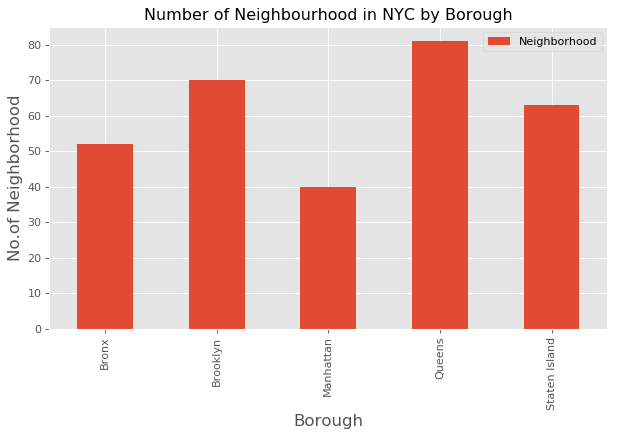

In [34]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

Lets analyze further and see how many Tibetan restaurants there are in each neighborhood and burough and graph the results.

In [37]:
# prepare neighborhood list that contains indian restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
tibetan_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    tibetan_restaurant=venues[venues['Category']=='Tibetan Restaurant']   
    print('(',count,'/',len(new_york_data),')','Tibetan Restaurant in '+Neighborhood+', '+Borough+':'+str(len(tibetan_restaurant)))
    for restaurant_detail in tibetan_restaurant.values.tolist():
        id, name , category=resturant_detail
        tibetan_rest_ny = tibetan_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Tibetan Restaurant in Wakefield, Bronx:0
( 2 / 306 ) Tibetan Restaurant in Co-op City, Bronx:0
( 3 / 306 ) Tibetan Restaurant in Eastchester, Bronx:0
( 4 / 306 ) Tibetan Restaurant in Fieldston, Bronx:0
( 5 / 306 ) Tibetan Restaurant in Riverdale, Bronx:0
( 6 / 306 ) Tibetan Restaurant in Kingsbridge, Bronx:0
( 7 / 306 ) Tibetan Restaurant in Marble Hill, Manhattan:0
( 8 / 306 ) Tibetan Restaurant in Woodlawn, Bronx:0
( 9 / 306 ) Tibetan Restaurant in Norwood, Bronx:0
( 10 / 306 ) Tibetan Restaurant in Williamsbridge, Bronx:0
( 11 / 306 ) Tibetan Restaurant in Baychester, Bronx:0
( 12 / 306 ) Tibetan Restaurant in Pelham Parkway, Bronx:0
( 13 / 306 ) Tibetan Restaurant in City Island, Bronx:0
( 14 / 306 ) Tibetan Restaurant in Bedford Park, Bronx:0
( 15 / 306 ) Tibetan Restaurant in University Heights, Bronx:0
( 16 / 306 ) Tibetan Restaurant in Morris Heights, Bronx:0
( 17 / 306 ) Tibetan Restaurant in Fordham, Bronx:0
( 18 / 306 ) Tibetan Restaurant in East Tremont, Bronx:

( 141 / 306 ) Tibetan Restaurant in Sunnyside, Queens:0
( 142 / 306 ) Tibetan Restaurant in East Elmhurst, Queens:0
( 143 / 306 ) Tibetan Restaurant in Maspeth, Queens:0
( 144 / 306 ) Tibetan Restaurant in Ridgewood, Queens:0
( 145 / 306 ) Tibetan Restaurant in Glendale, Queens:0
( 146 / 306 ) Tibetan Restaurant in Rego Park, Queens:0
( 147 / 306 ) Tibetan Restaurant in Woodhaven, Queens:0
( 148 / 306 ) Tibetan Restaurant in Ozone Park, Queens:0
( 149 / 306 ) Tibetan Restaurant in South Ozone Park, Queens:0
( 150 / 306 ) Tibetan Restaurant in College Point, Queens:0
( 151 / 306 ) Tibetan Restaurant in Whitestone, Queens:0
( 152 / 306 ) Tibetan Restaurant in Bayside, Queens:0
( 153 / 306 ) Tibetan Restaurant in Auburndale, Queens:0
( 154 / 306 ) Tibetan Restaurant in Little Neck, Queens:0
( 155 / 306 ) Tibetan Restaurant in Douglaston, Queens:0
( 156 / 306 ) Tibetan Restaurant in Glen Oaks, Queens:0
( 157 / 306 ) Tibetan Restaurant in Bellerose, Queens:0
( 158 / 306 ) Tibetan Restaurant

( 276 / 306 ) Tibetan Restaurant in Stuyvesant Town, Manhattan:0
( 277 / 306 ) Tibetan Restaurant in Flatiron, Manhattan:0
( 278 / 306 ) Tibetan Restaurant in Sunnyside Gardens, Queens:0
( 279 / 306 ) Tibetan Restaurant in Blissville, Queens:0
( 280 / 306 ) Tibetan Restaurant in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Tibetan Restaurant in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Tibetan Restaurant in Weeksville, Brooklyn:0
( 283 / 306 ) Tibetan Restaurant in Broadway Junction, Brooklyn:0
( 284 / 306 ) Tibetan Restaurant in Dumbo, Brooklyn:0
( 285 / 306 ) Tibetan Restaurant in Manor Heights, Staten Island:0
( 286 / 306 ) Tibetan Restaurant in Willowbrook, Staten Island:0
( 287 / 306 ) Tibetan Restaurant in Sandy Ground, Staten Island:0
( 288 / 306 ) Tibetan Restaurant in Egbertville, Staten Island:0
( 289 / 306 ) Tibetan Restaurant in Roxbury, Queens:0
( 290 / 306 ) Tibetan Restaurant in Homecrest, Brooklyn:0
( 291 / 306 ) Tibetan Restaurant in Middle Village, Queens:0
( 292 / 306 ) Tibet

In [38]:
tibetan_rest_ny.to_csv('tibetan_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [39]:
tibetan_rest_ny = pd.read_csv('tibetan_rest_ny_tocsv1.csv')
tibetan_rest_ny.tail(10)

,Unnamed: 0,Borough,Neighborhood,ID,Name
5,5,Queens,Woodside,4aa2d9f1f964a520534220e3,Cafe Tibet
6,6,Queens,Jackson Heights,4aa2d9f1f964a520534220e3,Cafe Tibet
7,7,Queens,Elmhurst,4aa2d9f1f964a520534220e3,Cafe Tibet
8,8,Queens,Elmhurst,4aa2d9f1f964a520534220e3,Cafe Tibet
9,9,Brooklyn,Ditmas Park,4aa2d9f1f964a520534220e3,Cafe Tibet


In [60]:
tibetan_rest_ny.shape

(10, 5)

As we continue our analysis, we see below that although Manhattan had the least number of nieghborhoods, it does have the least number of Tibetan restaurants too. Additionally, we see how many restaurants the top 5 neighborhoods have. The neighborhood of Queens has the highest number of Tibetan restaurants in all of NYC.

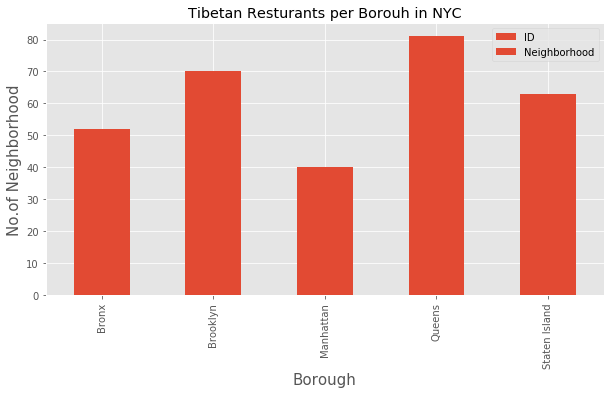

In [62]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')         
tibetan_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5))
# title
plt.title('Tibetan Resturants per Borouh in NYC')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

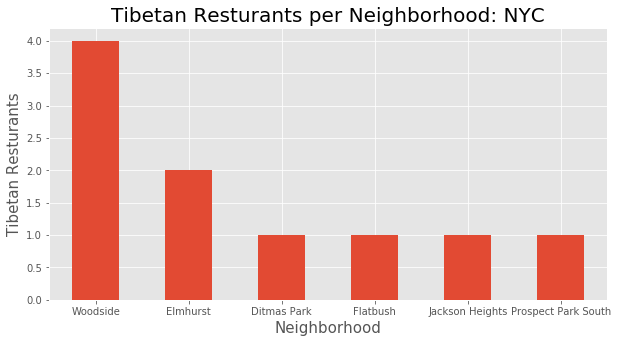

In [64]:
NOofNeigh = 10 # top number for graphing all the same past 6
tibetan_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5))
plt.title('Tibetan Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Tibetan Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [96]:
tibetan_rest_ny[tibetan_rest_ny['Neighborhood']=='Woodside']


,Unnamed: 0,Borough,Neighborhood,ID,Name
2,2,Queens,Woodside,4aa2d9f1f964a520534220e3,Cafe Tibet
3,3,Queens,Woodside,4aa2d9f1f964a520534220e3,Cafe Tibet
4,4,Queens,Woodside,4aa2d9f1f964a520534220e3,Cafe Tibet
5,5,Queens,Woodside,4aa2d9f1f964a520534220e3,Cafe Tibet


In [97]:
tibetan_rest_ny.drop(tibetan_rest_ny.columns[tibetan_rest_ny.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [98]:
tibetan_rest_ny[tibetan_rest_ny['Neighborhood']=='Woodside']

,Borough,Neighborhood,ID,Name
2,Queens,Woodside,4aa2d9f1f964a520534220e3,Cafe Tibet
3,Queens,Woodside,4aa2d9f1f964a520534220e3,Cafe Tibet
4,Queens,Woodside,4aa2d9f1f964a520534220e3,Cafe Tibet
5,Queens,Woodside,4aa2d9f1f964a520534220e3,Cafe Tibet


In [100]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
tibetan_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in tibetan_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(tibetan_rest_ny),')','processed')
    tibetan_rest_stats_ny = tibetan_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
tibetan_rest_stats_ny.tail()

                         ID        Name  Likes  Rating  Tips
0  4aa2d9f1f964a520534220e3  Cafe Tibet    132     8.3    71
( 1 / 10 ) processed
                         ID        Name  Likes  Rating  Tips
0  4aa2d9f1f964a520534220e3  Cafe Tibet    132     8.3    71
( 2 / 10 ) processed
                         ID        Name  Likes  Rating  Tips
0  4aa2d9f1f964a520534220e3  Cafe Tibet    132     8.3    71
( 3 / 10 ) processed
                         ID        Name  Likes  Rating  Tips
0  4aa2d9f1f964a520534220e3  Cafe Tibet    132     8.3    71
( 4 / 10 ) processed
                         ID        Name  Likes  Rating  Tips
0  4aa2d9f1f964a520534220e3  Cafe Tibet    132     8.3    71
( 5 / 10 ) processed
                         ID        Name  Likes  Rating  Tips
0  4aa2d9f1f964a520534220e3  Cafe Tibet    132     8.3    71
( 6 / 10 ) processed
                         ID        Name  Likes  Rating  Tips
0  4aa2d9f1f964a520534220e3  Cafe Tibet    132     8.3    71
( 7 / 10 ) processed

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
5,Queens,Woodside,4aa2d9f1f964a520534220e3,Cafe Tibet,132,8.3,71
6,Queens,Jackson Heights,4aa2d9f1f964a520534220e3,Cafe Tibet,132,8.3,71
7,Queens,Elmhurst,4aa2d9f1f964a520534220e3,Cafe Tibet,132,8.3,71
8,Queens,Elmhurst,4aa2d9f1f964a520534220e3,Cafe Tibet,132,8.3,71
9,Brooklyn,Ditmas Park,4aa2d9f1f964a520534220e3,Cafe Tibet,132,8.3,71


In [101]:
tibetan_rest_stats_ny.to_csv('tibetan_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [102]:
tibetan_rest_stats_ny.shape

(10, 7)

In [103]:
tibetan_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
Borough         10 non-null object
Neighborhood    10 non-null object
ID              10 non-null object
Name            10 non-null object
Likes           10 non-null object
Rating          10 non-null float64
Tips            10 non-null object
dtypes: float64(1), object(6)
memory usage: 640.0+ bytes


In [105]:
tibetan_rest_stats_ny['Likes']=tibetan_rest_stats_ny['Likes'].astype('float64')
tibetan_rest_stats_ny['Tips']=tibetan_rest_stats_ny['Tips'].astype('float64')
tibetan_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
Borough         10 non-null object
Neighborhood    10 non-null object
ID              10 non-null object
Name            10 non-null object
Likes           10 non-null float64
Rating          10 non-null float64
Tips            10 non-null float64
dtypes: float64(3), object(4)
memory usage: 640.0+ bytes


In [106]:
tibetan_rest_stats_ny.describe()

,Likes,Rating,Tips
count,10.0,1.000000e+01,10.0
mean,132.0,8.300000e+00,71.0
std,0.0,1.872445e-15,0.0
min,132.0,8.300000e+00,71.0
25%,132.0,8.300000e+00,71.0
50%,132.0,8.300000e+00,71.0
75%,132.0,8.300000e+00,71.0
max,132.0,8.300000e+00,71.0


In [108]:
# Resturant with maximum Likes
tibetan_rest_stats_ny.iloc[tibetan_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Flatbush
ID              4aa2d9f1f964a520534220e3
Name                          Cafe Tibet
Likes                                132
Rating                               8.3
Tips                                  71
Name: 0, dtype: object

In [109]:
# Resturant with maximum Ratings
tibetan_rest_stats_ny.iloc[tibetan_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Flatbush
ID              4aa2d9f1f964a520534220e3
Name                          Cafe Tibet
Likes                                132
Rating                               8.3
Tips                                  71
Name: 0, dtype: object

In [110]:
# Resturant with maximum Tips
tibetan_rest_stats_ny.iloc[tibetan_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Flatbush
ID              4aa2d9f1f964a520534220e3
Name                          Cafe Tibet
Likes                                132
Rating                               8.3
Tips                                  71
Name: 0, dtype: object

In [111]:
ny_neighborhood_stats=tibetan_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Ditmas Park,8.3
1,Elmhurst,8.3
2,Flatbush,8.3
3,Jackson Heights,8.3
4,Prospect Park South,8.3
5,Woodside,8.3


In [112]:
ny_borough_stats=tibetan_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Brooklyn,8.3
1,Queens,8.3


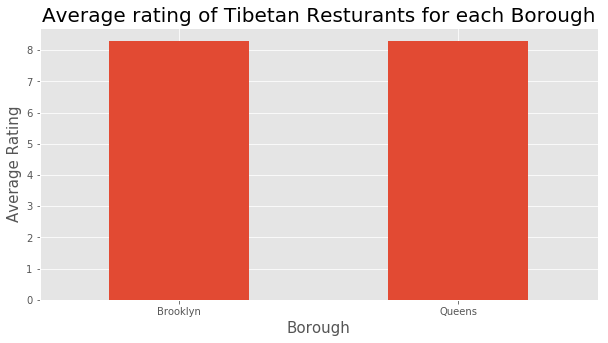

In [174]:
tibetan_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5))
plt.title('Average rating of Tibetan Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

We will visually map the neighborhoods with an average rating greater than or equal to 8 after joining the approprite dfs to include latitudes and longitudes.

In [121]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Ditmas Park,8.3
1,Elmhurst,8.3
2,Flatbush,8.3
3,Jackson Heights,8.3
4,Prospect Park South,8.3
5,Woodside,8.3


In [134]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [135]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [159]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
0,Brooklyn,Ditmas Park,40.643675,-73.961013,8.3,"Ditmas Park, Brooklyn(8.3)"
182,Queens,Woodside,40.746349,-73.901842,8.3,"Woodside, Queens(8.3)"
188,Queens,Woodside,40.746349,-73.901842,8.3,"Woodside, Queens(8.3)"
187,Queens,Woodside,40.746349,-73.901842,8.3,"Woodside, Queens(8.3)"
186,Queens,Woodside,40.746349,-73.901842,8.3,"Woodside, Queens(8.3)"
185,Queens,Woodside,40.746349,-73.901842,8.3,"Woodside, Queens(8.3)"
184,Queens,Woodside,40.746349,-73.901842,8.3,"Woodside, Queens(8.3)"
183,Queens,Woodside,40.746349,-73.901842,8.3,"Woodside, Queens(8.3)"
181,Queens,Woodside,40.746349,-73.901842,8.3,"Woodside, Queens(8.3)"
173,Queens,Woodside,40.746349,-73.901842,8.3,"Woodside, Queens(8.3)"


In [153]:
# create map and display it
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [154]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [155]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

The curated dataframe is then used to visualize by creating a map of New York City with neighborhoods superimposed on top for Tibetan Restaurants. The following depiction is a map generated using python ‘folium’ library.

In [156]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

### Findings
- All Tibetan restaurants in NYC have the same rating.
- Queens and Brooklyn are the only boroughs where Tibetan Resturants located.
- There is no Tibetan Restaurant in Bronx, State Island and Manhathan.
- The majority of Tibetan restaurants is located in Queens.
- Queens is the best place to stay if you prefer Tibetan Cuisine.

###  Recommendation
Jackson Heights, Elmhurst and Woodside of Queens would be the best choice to start a Tibetan restaurant given that many Tibetans are living in Queens (NYC).



### Limitations
- The ranking is purely on basis of rating of resturants.
- The accuracy of data depends purely depends on the data provided by FourSquare